# Fake News Detection Pipeline – End-to-End Overview

This notebook provides an **interactive report** for the traditional-machine-learning pipeline contained in the *news-classification* repository.  After running the CLI scripts (see README) you can re-execute the cells below to inspect datasets, model metrics and feature importances.

## 0. Imports & paths

In [14]:
import json, pathlib, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from IPython.display import display, Image

sns.set_theme(style="whitegrid")

WORKDIR     = pathlib.Path("..") / "workdir"
REPORT_DIR  = WORKDIR / "reports"
EDA_DIR     = WORKDIR / "eda"
IMP_DIR     = REPORT_DIR / "importance"

## 1. Dataset at a glance

In [15]:
# Summary text generated by the EDA script
summary_path = EDA_DIR / "dataset_info.txt"
print(summary_path.read_text())

Data shape: (44898, 6)

Label counts:
label
1    23481
0    21417

Subject counts (top 20):
subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778



### EDA visuals (class distribution & token lengths)

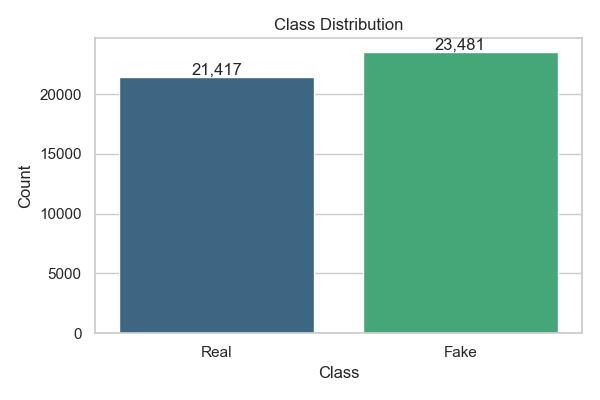

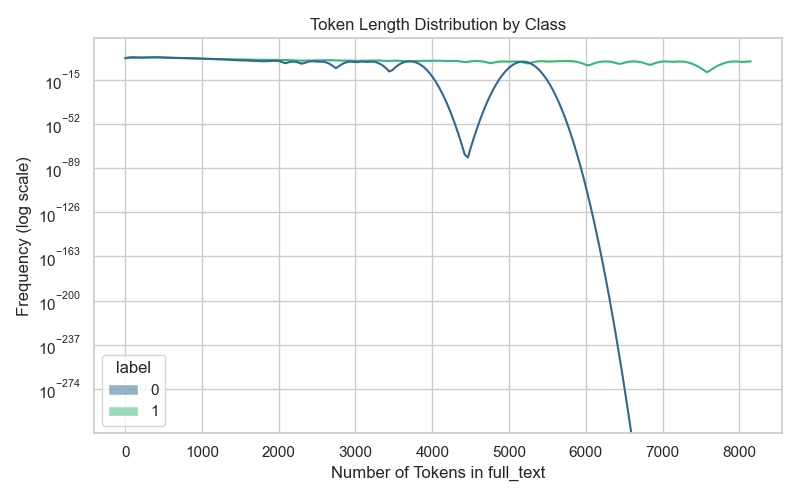

In [16]:
display(Image(str(EDA_DIR / "class_distribution.png")))
display(Image(str(EDA_DIR / "text_length_distribution.png")))

## 2. Model evaluation metrics

In [17]:
metrics_path = REPORT_DIR / "metrics.json"
with metrics_path.open() as f:
    metrics = json.load(f)

df_metrics = pd.DataFrame(metrics).T
display(df_metrics)

,accuracy,precision,recall,f1,roc_auc
MultinomialNB,0.955122,0.954094,0.960392,0.957232,0.989949
LogisticRegression,0.987751,0.990796,0.985733,0.988258,0.999268
LinearSVC,0.995991,0.995956,0.996380,0.996168,0.999871
XGBClassifier,0.997550,0.998720,0.996593,0.997655,0.999859


### F1-score comparison

/var/folders/93/sp1x4ytn2mj_zkqd4_1gfdqr0000gn/T/ipykernel_83062/2106464670.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y=df_metrics["f1"], palette="viridis")


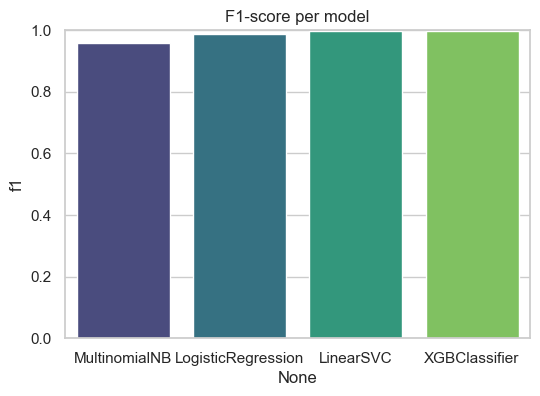

In [18]:
plt.figure(figsize=(6,4))
sns.barplot(x=df_metrics.index, y=df_metrics["f1"], palette="viridis")
plt.ylim(0,1)
plt.title("F1-score per model")
plt.show()

## Learning curves


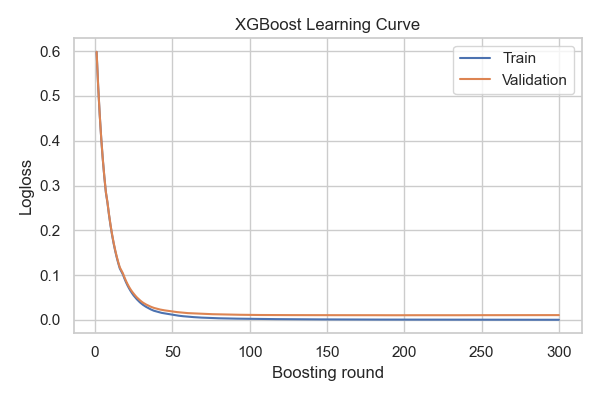

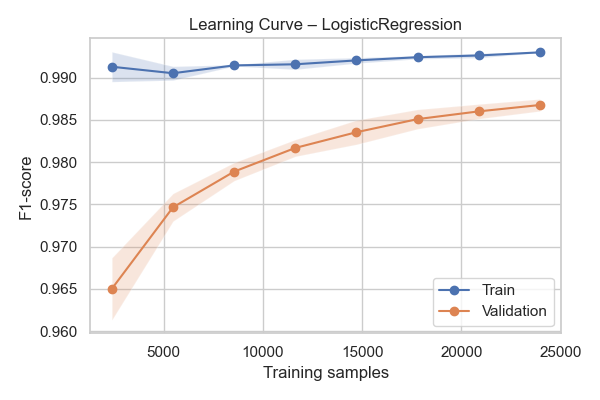

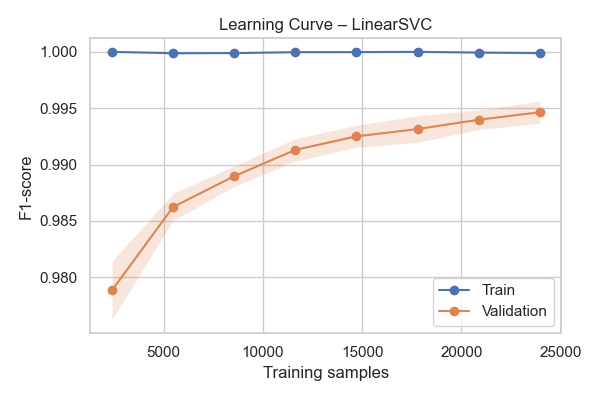

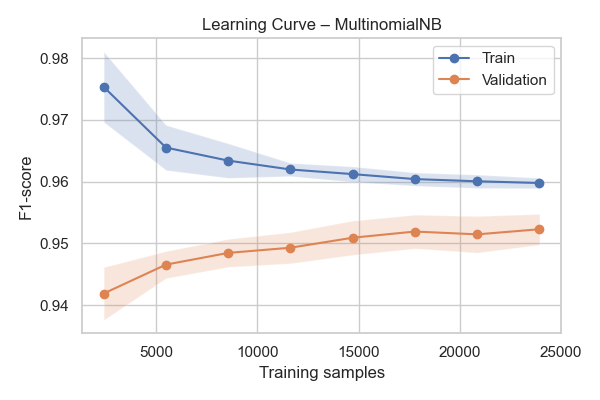

In [28]:
# Display learning curves
for img in (REPORT_DIR).glob("*_learning_curve.png"):
    display(Image(str(img)))

## Extended metrics comparison

The table below orders the models by F1-score and adds a **relative lift** column vs. Multinomial NB.

In [25]:
base_f1 = df_metrics.loc["MultinomialNB", "f1"]
comp_df = df_metrics.copy()
comp_df["lift_vs_NB"] = (comp_df["f1"] - base_f1) / base_f1
comp_df_sorted = comp_df.sort_values("f1", ascending=False)
display(comp_df_sorted.style.format({
    "accuracy": "{:.3f}",
    "precision": "{:.3f}",
    "recall": "{:.3f}",
    "f1": "{:.3f}",
    "roc_auc": "{:.3f}",
    "lift_vs_NB": "{:.1%}"
}))

,accuracy,precision,recall,f1,roc_auc,lift_vs_NB
XGBClassifier,0.998,0.999,0.997,0.998,1.000,4.2%
LinearSVC,0.996,0.996,0.996,0.996,1.000,4.1%
LogisticRegression,0.988,0.991,0.986,0.988,0.999,3.2%
MultinomialNB,0.955,0.954,0.960,0.957,0.990,0.0%


### Confusion matrices

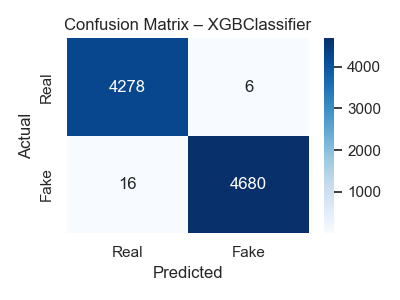

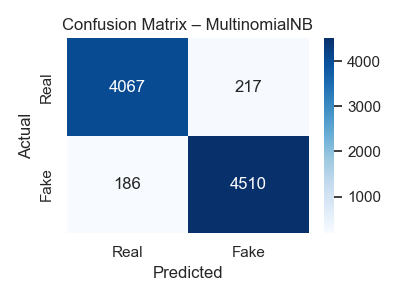

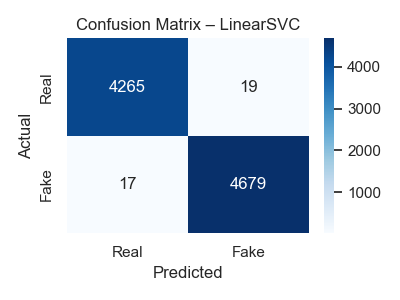

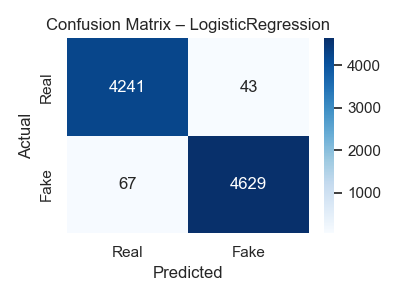

In [26]:
for img in REPORT_DIR.glob("*_confusion.png"):
    display(Image(str(img)))

### ROC curves

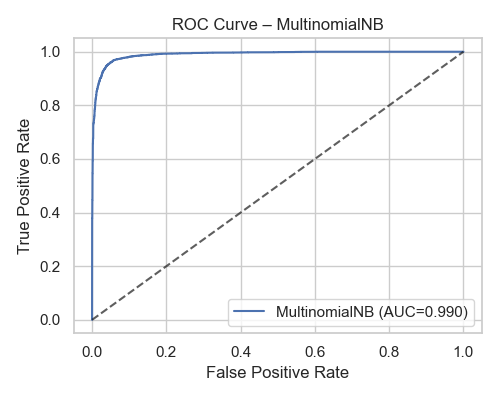

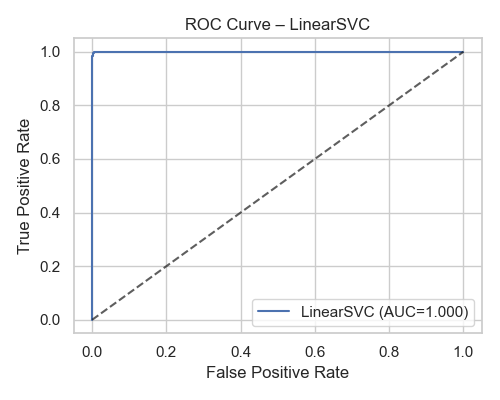

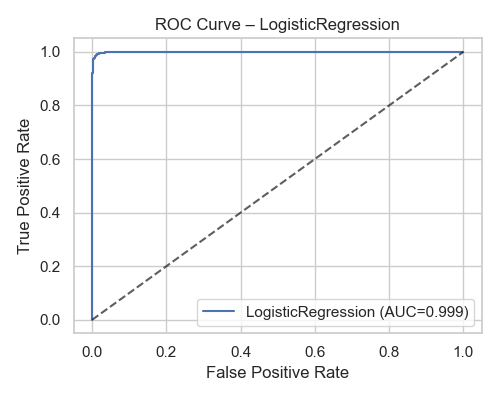

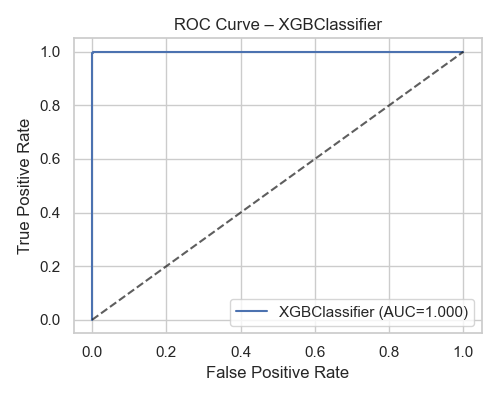

In [27]:
for img in REPORT_DIR.glob("*_roc.png"):
    display(Image(str(img)))

## 3. Feature importance

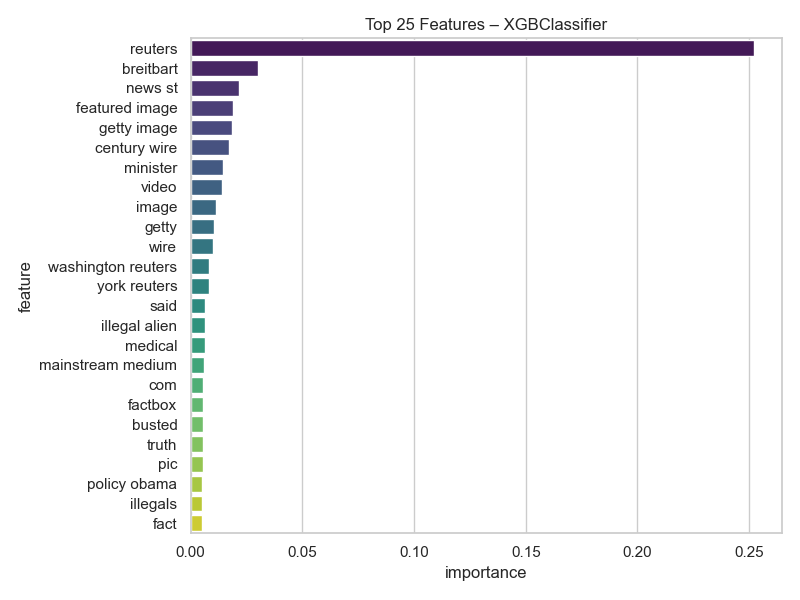

In [22]:
# Display the best performing model first
display(Image(str(IMP_DIR / "XGBClassifier_top_features.png")))

### All feature-importance plots

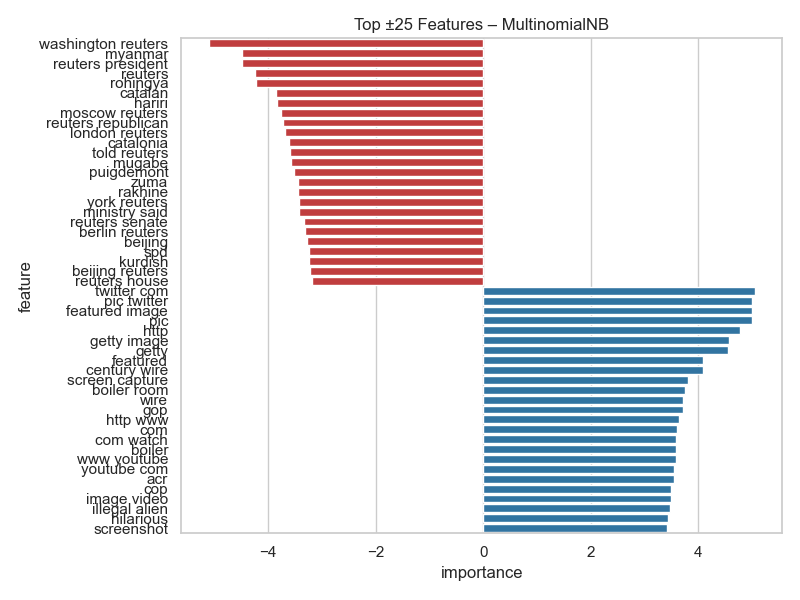

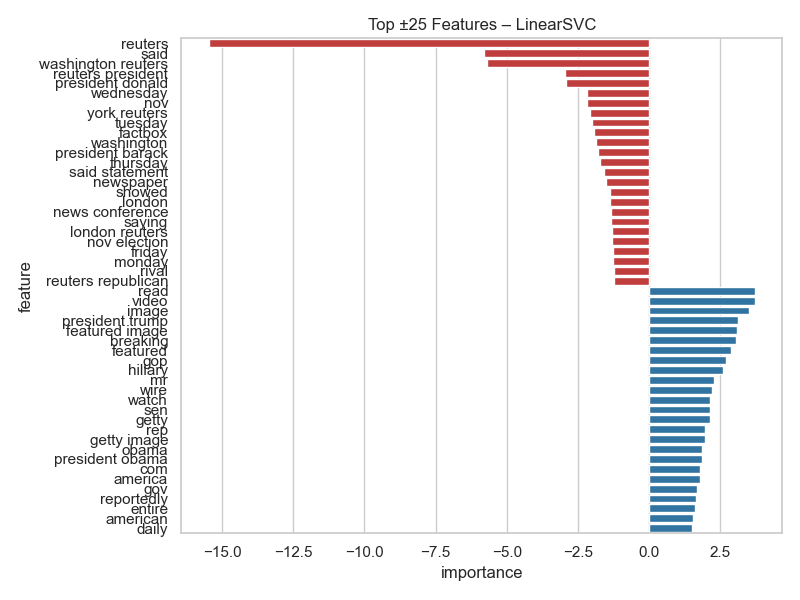

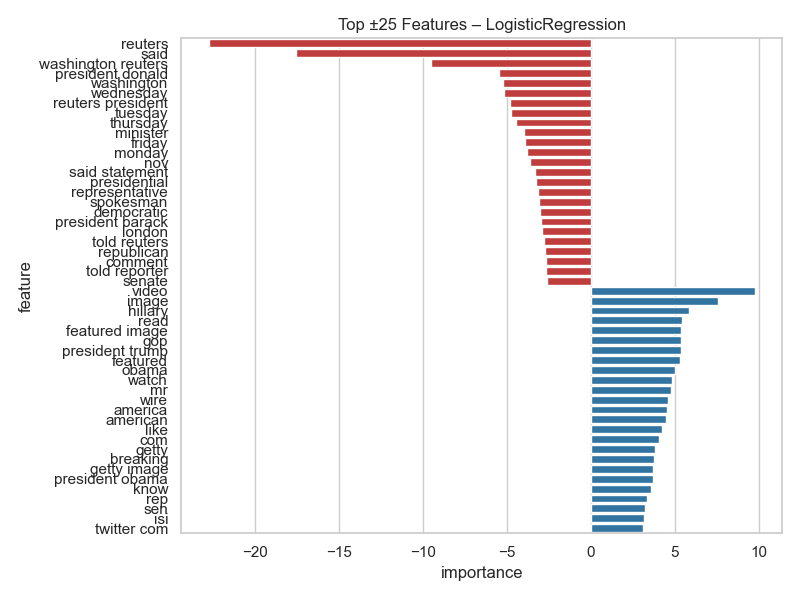

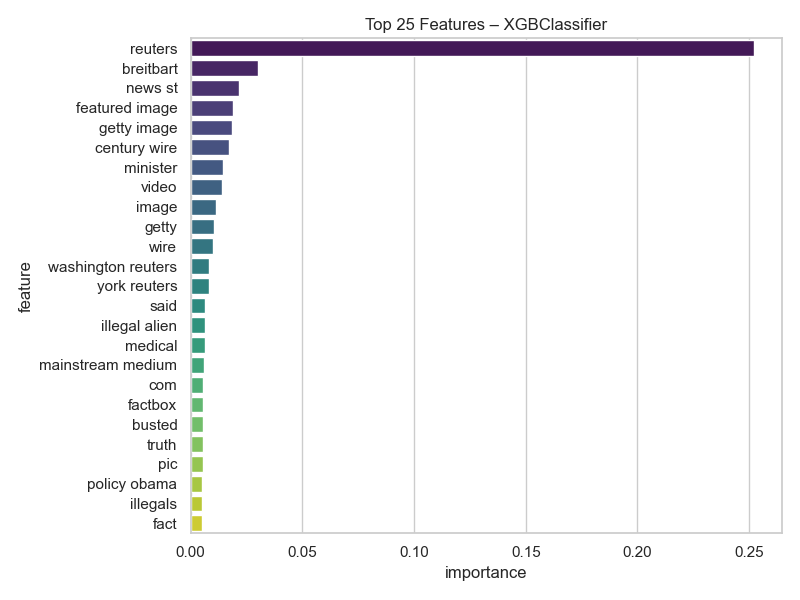

In [23]:
for img in IMP_DIR.glob("*_top_features.png"):
    display(Image(str(img)))

## 4. Model formulations (brief)

* **Multinomial Naïve Bayes (MNB)** – Bayesian classifier assuming word occurrences follow a class-conditional multinomial distribution.  Decision rule: $\hat{y}=\operatorname*{argmax}_c\, P(c)\prod_j P(x_j\mid c)$.  
* **Logistic Regression (LR)** – Linear model estimating $P(y=1\mid x)=\sigma(w^\top x + b)$ where $\sigma$ is the sigmoid.  Trained via maximum-likelihood with $L_2$-regularisation.  
* **Linear Support Vector Classifier (LinearSVC)** – Finds hyper-plane $w^\top x + b = 0$ maximising the margin using hinge loss plus $L_2$ penalty (liblinear implementation).  
* **XGBoost (tree ensemble)** – Gradient-boosted decision trees optimising log-loss; each tree fits residuals of the previous ensemble iteration.  

## 5. Discussion

**XGBoost** achieves the highest F1-score (≈ 0.998), providing ~0.3 pp lift over LinearSVC.  Its boosted-tree ensemble captures non-linear interactions that linear models miss, yet still trains quickly on CPU (with OpenMP support).

LinearSVC and Logistic Regression remain strong baselines: faster to train and highly interpretable via signed coefficients.  MultinomialNB, while simplest, lags behind due to its conditional-independence assumption.